In [1]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
import json
import urllib
import argparse
from pyspark.ml.feature import CountVectorizerModel
from pyspark.ml.clustering import LDA
%matplotlib inline

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.driver.memory','240g'),
                                   ('spark.driver.maxResultSize', '32G'),
                                   ('spark.local.dir', '/scratch/tmp/'),
                                   ('spark.yarn.stagingDir', '/scratch/tmp/'),
                                   ('spark.sql.warehouse.dir', '/scratch/tmp/')
                                  ])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
# create the context
sc = spark.sparkContext


In [2]:
spark

In [6]:
sites = ["enwiki", "eswiki", "itwiki", "dewiki", "frwiki", "cswiki", 
         "cawiki", "svwiki", "arwiki", 
             "elwiki",  "fiwiki", 
             "hewiki", "idwiki",  "kowiki", "nlwiki", "plwiki", 
             "ptwiki", "rowiki", "ruwiki", "sqwiki", "srwiki", "trwiki", 
             "ukwiki", "viwiki", "warwiki", "zhwiki", "fawiki", "jawiki"]


In [6]:
k = 40

In [ ]:
from pyspark.ml.clustering import LocalLDAModel
from pyspark.ml.feature import CountVectorizerModel
import numpy

model = LocalLDAModel.load("models/EnrichedLinks/limit500_LDA_model_{}_50iter.model".format(k))
transformer = CountVectorizerModel.load("models/EnrichedLinks/limit500_transformer.model")

vocab = numpy.array(transformer.vocabulary)

In [ ]:
def get_random (dataset, n):
    count = dataset.count()
    howManyTake = n if (count > n) else count
    return dataset.sample(False, 1.0 * howManyTake / count, seed=12345).limit(n)

In [ ]:
all_links_enriched_rdd = sc.emptyRDD()
for s in sites:
    links = spark.read.parquet("datasets/{}/enriched_all_links.parquet".format(s)).where("SIZE(links)>10")
    links_sample = get_random(links, 20000)
    all_links_enriched_rdd = all_links_enriched_rdd.union(links_sample.selectExpr("'{}' as site".format(s), "*").rdd)
    
all_links_enriched = spark.createDataFrame(all_links_enriched_rdd).cache()

In [ ]:
result = transformer.transform(all_links_enriched).cache()

In [ ]:
topics_distribution = model.transform(result)

In [ ]:
documents = []
for s in sites:
    documents+=topics_distribution.where("site='{}'".format(s)).collect()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

topic_centers = np.zeros(shape=(k,k))
for i in range(k):
    topic_centers[i][i]=1

full_matrix = [np.array(x.topicDistribution) for x in documents]+ topic_centers.tolist()

-----------

Consider saving, release the memory and load only the subsample.

In [20]:
np.save("Enriched40Random20k", full_matrix)
import pickle
pickle.dump( documents , open( "Enriched40Random20k_data.pkl", "wb" ) )

In [ ]:
import numpy as np
import pandas as pd
import pickle

full_matrix = np.load("Enriched40Random20k.npy")
documents = pickle.load( open( "Enriched40Random20k_data.pkl", "rb" ) )

-----

### Compute T-SNE reduction

In [3]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(full_matrix)

In [4]:
import pandas as pd

data = []
for idx in range(0, len(documents)):
    data.append({"site": documents[idx].site, "x": X_embedded[idx][0], "y": X_embedded[idx][1]})
    
data = pd.DataFrame(data)
data.head(5)

,site,x,y
0,enwiki,-0.879598,6.760465
1,enwiki,-24.859644,-12.898977
2,enwiki,-14.138106,-18.457375
3,enwiki,-2.477220,-1.663482
4,enwiki,-7.965023,31.080669


-----------

Save to release memory. Restarting the kernel and load from disk could be a good idea.

In [5]:
import numpy
data.to_pickle("TSNE-28langs_Enriched40topics.pkl")
numpy.save("X_embedded_TSNE-28langs_Enriched40topics.npy", X_embedded)

In [1]:
import pandas as pd
import numpy

data = pd.read_pickle("TSNE-28langs_Enriched40topics.pkl")
X_embedded = numpy.load("X_embedded_TSNE-28langs_Enriched40topics.npy")
documents = pd.read_pickle("Enriched40Random20k_data.pkl")

------

In [3]:
len(data)

556303

In [4]:
len(X_embedded)

556503

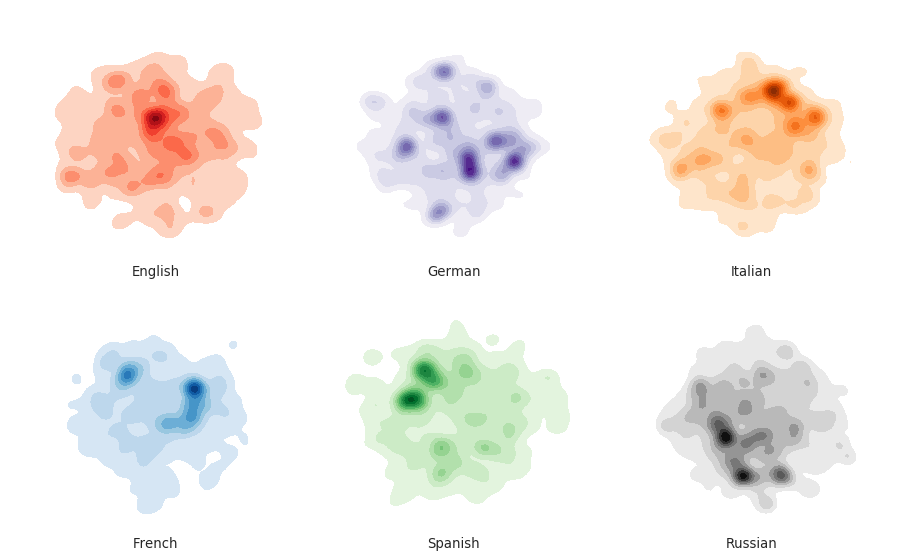

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})

f, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)

def format_plot(ax, title):
    ax.set_title(title, y=-0.01)
    ax.axis('off')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.subplots_adjust(wspace = .001)


enwiki = data[data.site=="enwiki"]
ax = sns.kdeplot(enwiki.x, enwiki.y,
                 cmap="Reds", shade=True, shade_lowest=False, ax=axes[0][0])
format_plot(axes[0][0], "English")

dewiki = data[data.site=="dewiki"]
ax = sns.kdeplot(dewiki.x, dewiki.y,
                 cmap="Purples", shade=True, shade_lowest=False, ax=axes[0][1])
format_plot(axes[0][1], "German")

itwiki = data[data.site=="itwiki"]
ax = sns.kdeplot(itwiki.x, itwiki.y,
                 cmap="Oranges", shade=True, shade_lowest=False, ax=axes[0][2])
axes[0][2].set_title("Italian")
format_plot(axes[0][2], "Italian")

plt.subplots_adjust(hspace = .001)

frwiki = data[data.site=="frwiki"]
ax = sns.kdeplot(frwiki.x, frwiki.y,
                 cmap="Blues", shade=True, shade_lowest=False, ax=axes[1][0])
format_plot(axes[1][0], "French")

eswiki = data[data.site=="eswiki"]
ax = sns.kdeplot(eswiki.x, eswiki.y,
                 cmap="Greens", shade=True, shade_lowest=False, ax=axes[1][1])
format_plot(axes[1][1], "Spanish")

ruwiki = data[data.site=="ruwiki"]
ax = sns.kdeplot(ruwiki.x, ruwiki.y,
                 cmap="Greys", shade=True, shade_lowest=False, ax=axes[1][2])
format_plot(axes[1][2], "Russian")

plt.savefig("topics_projection_k40.pdf")

In [8]:
languages = {'enwiki': 'English', 'eswiki': "Spanish", 'itwiki': 'Italian', 'dewiki': "German", 
         'frwiki':'French', 'cswiki':'Czech',
       'cawiki':'Catalan', 'svwiki':'Swedish', 'arwiki':'Arabic', 'elwiki':'Greek', 
         'fiwiki':'Finnish', 'hewiki':'Hebrew',
       'idwiki':'Indonesian', 'kowiki':'Korean', 'nlwiki':'Dutch', 'plwiki':'Polish', 'ptwiki':'Portuguese', 
     'rowiki':'Romanian',
       'ruwiki': 'Russian', 'sqwiki':'Albanian', 'srwiki':'Serbian', 'trwiki':'Turkish', 'ukwiki':'Ukrainian', 'viwiki':'Vietnamese',
       'warwiki':'Waray', 'zhwiki':'Chinese', 'fawiki':'Persian', 'jawiki':'Japanese'}

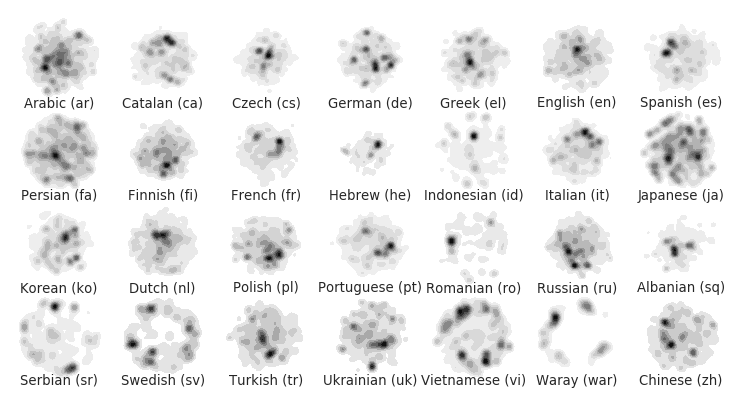

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})

cols = 7

f, axes = plt.subplots(len(sites)//cols, cols, figsize=(13, 7), sharex=True, sharey=True)

sorted_sites = sorted(sites)

def format_plot(ax, title):
    ax.set_title("{} ({})".format(languages.get(title), title.replace("wiki","")), y=-0.03)
    ax.axis('off')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.subplots_adjust(wspace = -.001)
    plt.subplots_adjust(hspace = -.1)


for idx in range(len(sorted_sites)):
    s = sorted_sites[idx]
    wiki = data[data.site==s]#.head(3)
    ax = sns.kdeplot(wiki.x, wiki.y,
                     cmap="Greys", shade=True, shade_lowest=False, ax=axes[idx//cols][idx%cols])
    format_plot(axes[idx//cols][idx%cols], s)

    
plt.savefig("topics_projection_k40_all.pdf", bbox_inches = 'tight', pad_inches = 0)